TEXT -> TOKENS -> PADDED -> EMBEDDING DIN TF

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nltk
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout
from keras.layers import Embedding
from keras_preprocessing.sequence import pad_sequences

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoscaMitrut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
therapis_responses = pd.read_csv("data/Therapist_responses.csv",delimiter=",")
annotated_data = pd.read_csv("data/Annotated_data.csv",delimiter=",")
annotated_data_copy = pd.read_csv("data/Annotated_data.csv",delimiter=",")
merged_data = pd.merge(therapis_responses,annotated_data,on='Id_Number')

In [7]:
annotated_data_copy

,Id_Number,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,4500,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,4501,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,4502,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,4503,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,4504,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...,...
2525,2562,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,2563,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,2564,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,2565,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [4]:
def label_distorsion_binary(row):  
    if row["Dominant Distortion"] == "All-or-nothing thinking":
        return 1
    if row["Dominant Distortion"] == "Overgeneralization":
        return 2
    if row["Dominant Distortion"] == "Mental filter":
        return 3
    if row["Dominant Distortion"] == "Should statements":
        return 4
    if row["Dominant Distortion"] == "Labeling":
        return 5
    if row["Dominant Distortion"] == "Personalization":
        return 6
    if row["Dominant Distortion"] == "Magnification":
        return 7
    if row["Dominant Distortion"] == "Emotional Reasoning":
        return 8
    if row["Dominant Distortion"] == "Mind Reading":
        return 9
    if row["Dominant Distortion"] == "Fortune-telling":
        return 10
    return 0

annotated_data_copy["Distortion"] = annotated_data_copy.apply(label_distorsion_binary, axis=1)
annotated_data_copy = annotated_data_copy.drop(['Distorted part','Dominant Distortion','Secondary Distortion (Optional)'],axis=1)

In [5]:
annotated_data_copy

,Id_Number,Patient Question,Distortion
0,4500,"Hello, I have a beautiful,smart,outgoing and a...",6
1,4501,Since I was about 16 years old I’ve had these ...,5
2,4502,So I’ve been dating on and off this guy for a...,0
3,4503,My parents got divorced in 2004. My mother has...,0
4,4504,I don’t really know how to explain the situati...,10
...,...,...,...
2525,2562,I’m a 21 year old female. I spent most of my l...,0
2526,2563,I am 21 female and have not had any friends fo...,2
2527,2564,From the U.S.: My brother is 19 years old and ...,3
2528,2565,From the U.S.: I am a 21 year old woman who ha...,0


In [14]:
annotated_data_copy.values.tolist()

[[4500,
  'Hello, I have a beautiful,smart,outgoing and amazing five year old little girl. Yesterday she came to me and said mom can you take me to the doctor. I ask her what was wrong and she replied: I hear voices in my ears but I dont see the people saying it. She says it happened during school doing a reading circle. She thought someone called her stupid and let the teacher know. The teacher said no one said anything. It happened again when my husband was talking to my other children, she said I heard daddy say shut up, but he didnt really say it. The voice are always fimilar (someone she knows) Im very concerned about this and hope it has nothing to do with my pregnancy while on active duty.',
  6],
 [4501,
  'Since I was about 16 years old I’ve had these “spells” where it’s impossible for me to control my emotions. They come on suddenly and with absolutely no triggers whatsoever, although for hours to days before they happen I’ll sometimes have uncomfortably high levels of energy

In [6]:
def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)
def find_max_list(list):
    list_len = [len(i) for i in list]
    return max(list_len)

texts = annotated_data_copy.values.tolist()

sentences = [el[1] for el in texts]
sentences = list(map(remove_stop_words,sentences))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

sequences

[[297,
  987,
  826,
  2385,
  749,
  852,
  20,
  34,
  98,
  118,
  1120,
  205,
  51,
  47,
  89,
  265,
  229,
  80,
  2845,
  260,
  306,
  2073,
  200,
  36,
  10,
  185,
  137,
  179,
  30,
  597,
  1950,
  57,
  48,
  311,
  476,
  177,
  719,
  3,
  719,
  51,
  15,
  51,
  31,
  179,
  104,
  108,
  254,
  51,
  483,
  2386,
  56,
  732,
  943,
  11,
  56,
  417,
  14,
  6788,
  48,
  398,
  99,
  450,
  505,
  95,
  1327,
  1328,
  3165],
 [23,
  7,
  34,
  3166,
  853,
  173,
  256,
  119,
  686,
  634,
  2387,
  1840,
  319,
  244,
  114,
  341,
  43,
  5096,
  180,
  1951,
  2,
  240,
  5097,
  1666,
  171,
  914,
  33,
  106,
  309,
  11,
  2388,
  4198,
  180,
  854,
  138,
  5098,
  211,
  733,
  109,
  12,
  180,
  1951,
  854,
  3166,
  563,
  647,
  2215,
  437,
  720,
  2588,
  6789,
  59,
  1598,
  2,
  1082,
  384,
  1599,
  231,
  1,
  1286,
  31,
  1480,
  2,
  1121,
  2074,
  263,
  1082,
  8,
  239,
  21,
  18,
  2,
  224,
  750,
  1430,
  1598,
  842,
  4199

In [7]:
VOCAB_LEN = len(tokenizer.word_index) + 1
MAX_LEN = find_max_list(sequences)
#MAX_LEN =200

padded_sequences = pad_sequences(sequences,maxlen=MAX_LEN, padding='post')

padded_sequences[:3]
#tokenizer.sequences_to_texts(padded_sequences)[:3]

array([[297, 987, 826, ...,   0,   0,   0],
       [ 23,   7,  34, ...,   0,   0,   0],
       [241, 175, 109, ...,   0,   0,   0]])

In [8]:
distortions = [el[2] for el in texts]
distortions = np.array(distortions)
distortions

array([6, 5, 0, ..., 3, 0, 0])

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, distortions)
METRICS = [
	tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

In [10]:
model = Sequential() 
n_dim = 2
model.add(Embedding(VOCAB_LEN, n_dim, input_length=MAX_LEN))#Vocabulary size of Tokenizer / Number of dimensions in embedding space / Length of padded sequence
model.add(Flatten())
model.add(Dense(2, activation='relu'))
model.add(Dense(11, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 492, 2)            23258     
                                                                 
 flatten (Flatten)           (None, 984)               0         
                                                                 
 dense (Dense)               (None, 2)                 1970      
                                                                 
 dense_1 (Dense)             (None, 11)                33        
                                                                 
Total params: 25,261
Trainable params: 25,261
Non-trainable params: 0
_________________________________________________________________


In [11]:
y_train_onehot = tf.keras.utils.to_categorical(Y_train)
y_test_onehot = tf.keras.utils.to_categorical(Y_test)
y_train_onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
X_train

array([[2115,  265,  505, ...,    0,    0,    0],
       [ 270,  933,  516, ...,    0,    0,    0],
       [  98,  583,    7, ...,    0,    0,    0],
       ...,
       [  20,   34,  118, ...,    0,    0,    0],
       [  99,    7,   34, ...,    0,    0,    0],
       [ 297,   79,  223, ...,    0,    0,    0]])

In [13]:
hist = model.fit(X_train,y_train_onehot,validation_data=(X_test,y_test_onehot),epochs=200)

Epoch 1/200
60/60 [==============================] - 3s 13ms/step - loss: 2.2919 - accuracy: 0.9091 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1722 - val_accuracy: 0.9091 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
60/60 [==============================] - 1s 8ms/step - loss: 2.1959 - accuracy: 0.9091 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1145 - val_accuracy: 0.9091 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
60/60 [==============================] - 0s 8ms/step - loss: 2.1117 - accuracy: 0.9091 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.0361 - val_accuracy: 0.9091 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
60/60 [==============================] - 1s 8ms/step - loss: 2.0508 - accuracy: 0.9111 - precision: 0.7188 - recall: 0.0364 - val_loss: 2.0070 - val_accuracy: 0.9123 - val_precision: 0.5567 - val_recall: 0.1706
Epoch 5/200
60/60 [==============================] - 1s 8ms

KeyboardInterrupt: 

20/20 [==============================] - 0s 3ms/step


Text(50.722222222222214, 0.5, 'Truth')

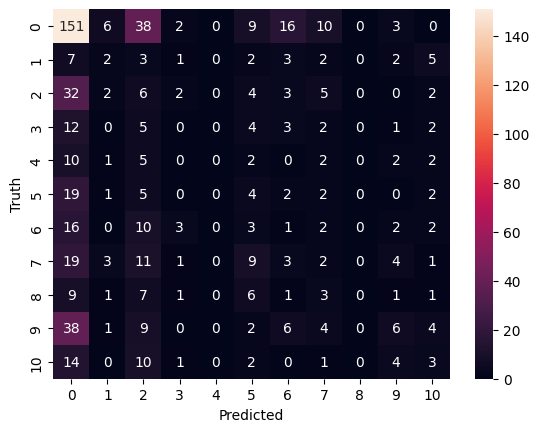

In [ ]:
y_predicted = model.predict(X_test)
predicted = [np.argmax(el) for el in y_predicted]
cm = confusion_matrix(Y_test, predicted)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')